**Importing Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import numpy as np
from skimage import data, io, img_as_ubyte, measure
from skimage.filters import threshold_multiotsu, threshold_otsu
from skimage.color import rgb2gray, label2rgb
from sklearn.cluster import KMeans
import cv2

from scipy import ndimage as nd 

**Setting constants**

In [2]:
IMG_SIZE = 1024
BATCH_SIZE = 10
CHANNELS = 3
EPOCHS = 100

**Loading data into tensorflow dataset object**

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE
)

# Getting the class names
class_names = dataset.class_names
class_names

Found 208 files belonging to 4 classes.


['-K', '-N', '-P', 'FN']

**Visualizing some of the images**

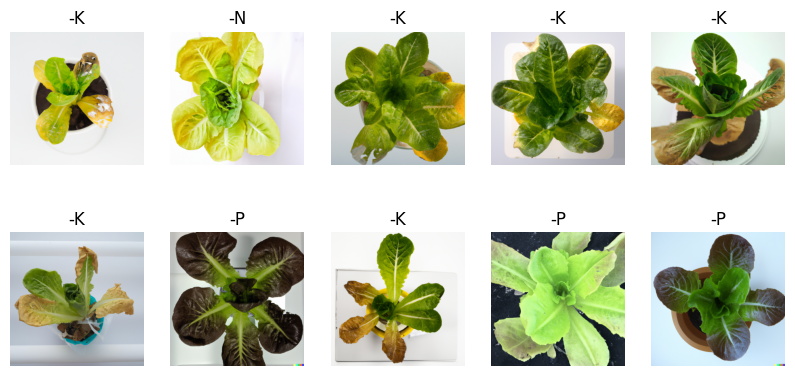

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

**Constants for data splitting**

In [7]:
dataset_size = len(dataset)       # 21 (number of pictures/batch_size)
train_size = 0.8                  # training = 10%
val_size = 0.1                    # validation = 10%
test_size = 0.1                   # test = 10%

**Function for data splitting**

In [8]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
  
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_data = ds.take(train_size)    
    val_data = ds.skip(train_size).take(val_size)
    test_data = ds.skip(train_size).skip(val_size)

    return train_data, val_data, test_data

**Data Splitting**

In [9]:
train_data, val_data, test_data = split_dataset(dataset)
len(train_data), len(val_data), len(test_data)

(16, 2, 3)

**Cache, Shuffle, and Prefetch**\
Cache - cache the dataset in memory\
Shuffle - shuffle the images\
Prefetch - overlaps the preprocessing and model execution of a training step\
This is to reduce memory usage and optimize the pipeline performance.
https://www.tensorflow.org/guide/data_performance

In [10]:
train_data = train_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

**Image Segmentation with Automatic Thresholding using Multi-Otsu (Grayscale)** \
Automatic Thresholding using Multi-Otsu was implemented to Keras as a custom layer using subclassing. Please visit [Tensorflow - Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) for more information. 

The [Otsu method](https://muthu.co/otsus-method-for-image-thresholding-explained-and-implemented/) utilizes the variance in the histogram to find the threshold used to segment the image. 

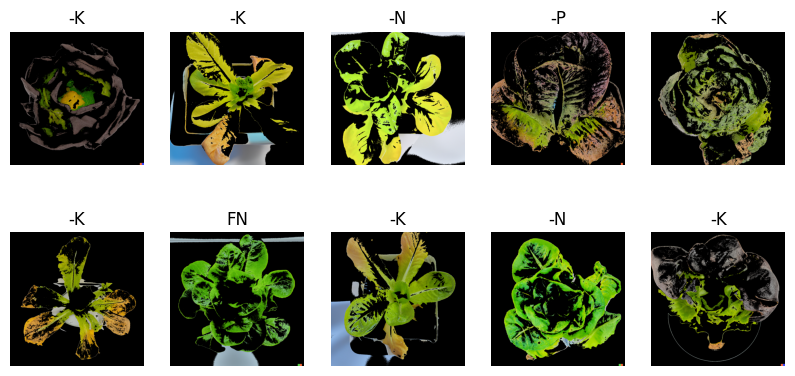

In [11]:
class MultiOtsuGray(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(MultiOtsuGray, self).__init__(**kwargs)

  def call(self, image):

    # Convert Tensor dtype to uint8 from float32
    image = tf.bitcast(tf.cast(image, tf.int8), tf.uint8)

    # Convert image to numpy array 
    np_image = image.numpy()

    # Convert image from RGB to Grayscale 
    gray = rgb2gray(np_image)

    # Find thresohld and get mask based on threshold
    ts = threshold_multiotsu(gray)
    binary_mask_1 = gray > ts[0] 
    binary_mask_2 = gray < ts[-1]  

    # Apply mask and convert from Numpy to Tensor
    np_image[~binary_mask_1] = 0
    np_image[~binary_mask_2] = 0

    # Convert Numpy to Tensor
    tf_image = tf.convert_to_tensor(np_image) 

    return tf_image      

MultiOtsuGray = tf.keras.Sequential([
  MultiOtsuGray()
])

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(10):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(MultiOtsuGray(image_batch[i]).numpy().astype('uint8'), cmap="gray")
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

**Image Segmentation with HSV Segmentation** \
Automatic Thresholding using Multi-Otsu was implemented to Keras as a custom layer using subclassing. Please visit [Tensorflow - Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) for more information.

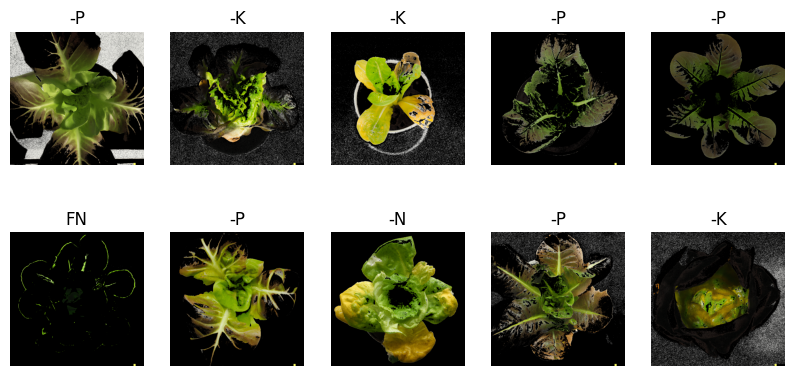

In [13]:
class HSVSegmentation(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(HSVSegmentation, self).__init__(**kwargs)

  def call(self, image):
    # Convert Tensor dtype to uint8 from float32
    image = tf.bitcast(tf.cast(image, tf.int8), tf.uint8)

    # Convert Tensor to numpy array  
    np_image = image.numpy()

    # Convert image from RGB to Grayscale 
    img_hsv = cv2.cvtColor(np_image, cv2.COLOR_RGB2HSV)

    # Get mask based on color range ang segment 
    green_mask = cv2.inRange(img_hsv, (30, 0, 0), (86,255,255))
    yellow_mask = cv2.inRange(img_hsv, (10, 0, 0), (30,255,255))
    brown_mask = cv2.inRange(img_hsv, (10,100,20), (20,255,200))
    mask_black = cv2.inRange(img_hsv, (0,0,0), (180,255,40))

    mask_total = green_mask + mask_black + yellow_mask + brown_mask
    segmented = cv2.bitwise_and(np_image, np_image, mask=mask_total)

    # Convert Numpy array to Tensor
    tf_image = tf.convert_to_tensor(segmented) 

    return tf_image      

HSVSegmentation = tf.keras.Sequential([
  HSVSegmentation()
])

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(10):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(HSVSegmentation(image_batch[i]).numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

**Image Segmentation with K-means Clustering** \
K-means clustering ([OpenCV K-means Clustering](https://docs.opencv.org/3.4/d1/d5c/tutorial_py_kmeans_opencv.html)) was implemented to Keras as a custom layer using subclassing. Please visit [Tensorflow - Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) for more information.

K-means, also known as clusterization, group objects into *k* clusters according to their traits. The process of grouping involves minimizing the total distances between each object and the centroid of the group or cluster.

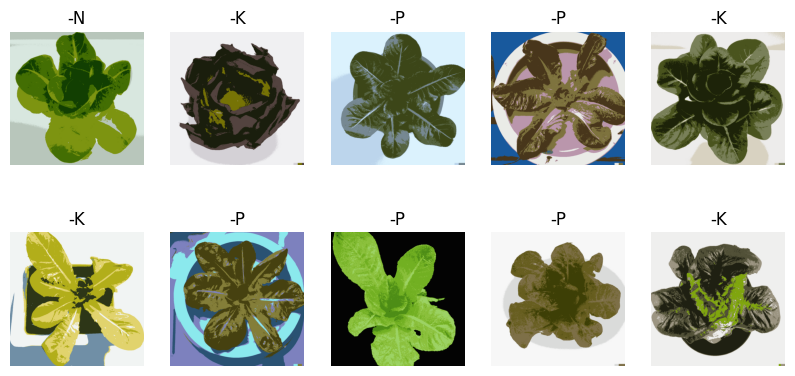

In [21]:
class KmeansSegmentation(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(KmeansSegmentation, self).__init__(**kwargs)

  def call(self, image):

    # Convert Tensor dtype to uint8 from float32
    image = tf.bitcast(tf.cast(image, tf.int8), tf.uint8)

    # Convert Tensor to numpy array  
    np_image = image.numpy()
    
    # Reshape since K-means is 2D
    res_image = np_image.reshape((-1,3))
    res_image = np.float32(res_image)
    
    # Define the stopping criteria 
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.5)
    
    # Define number of clusters and apply k-means
    K = 5
    ret, label, center = cv2.kmeans(res_image, K, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    labels = center[label.flatten()]
    
    # Reshape back
    segmented = labels.reshape((np_image.shape))
    
    # Convert from Numpy to Tensor
    tf_image = tf.convert_to_tensor(segmented)
    return tf_image   

KmeansSegmentation = tf.keras.Sequential([
    KmeansSegmentation()
])

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(10):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(KmeansSegmentation(image_batch[i]).numpy().astype('uint8'), cmap="gray")
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

**Image Segmentation with L\*a\*b and Otsu** \
The code uses Otsu Thresholding in the L\*a\*b color space, specifically the \*a and \*b for better segmentation as per [Yang et al.](https://www.sciencedirect.com/science/article/pii/S2214317321000834).

In [ ]:
class OtsuHSV(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(OtsuHSV, self).__init__(**kwargs)

  def call(self, image):
 
    #  Convert Tensor dtype to uint8 from float32
    image = tf.bitcast(tf.cast(image, tf.int8), tf.uint8)

    # Convert Tensor to numpy array  
    np_image = image.numpy()

    # Convert image from RGB to LAB and split channels
    img_lab = cv2.cvtColor(np_image, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(img_lab);
    
    # Get the threshold from the grayscaled a and b channels
    tsa = threshold_otsu(rgb2gray(cv2.merge([a,a,a])))
    tsb = threshold_otsu(rgb2gray(cv2.merge([b,b,b])))
    maska = rgb2gray(cv2.merge([a,a,a])) < tsa
    maskb = rgb2gray(cv2.merge([b,b,b])) > tsb

    # Mask by using the logical or on the a and b channels
    maskab = np.logical_or(maska, maskb)
    np_image[~maskab] = 0

    # Convert from Numpy to Tensor
    tf_image = tf.convert_to_tensor(np_image) 

    return tf_image      

OtsuHSV = tf.keras.Sequential([
  OtsuHSV()
])

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(10):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(OtsuHSV(image_batch[i]).numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

**Image Segmentation with L\*a\*b and Otsu Modified** \
The code uses Otsu Thresholding in the L\*a\*b color space, specifically the \*a and \*b for better segmentation as per [Yang et al.](https://www.sciencedirect.com/science/article/pii/S2214317321000834). This also makes use of the closing [morphological operation](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html) to better close the mask.

In [ ]:
class OtsuLab(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(OtsuLab, self).__init__(**kwargs)

  def call(self, image):
 
    #  Convert Tensor dtype to uint8 from float32
    image = tf.bitcast(tf.cast(image, tf.int8), tf.uint8)

    # Convert Tensor to numpy array  
    np_image = image.numpy()

    # Convert image from RGB to LAB and split channels
    img_lab = cv2.cvtColor(np_image, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(img_lab);

    tsa, ret1 = cv2.threshold(a,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    tsb, ret2 = cv2.threshold(b,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    ## Close holes using flood fill 
    # Mask by using the logical or on the a and b channels
    tsa3 = cv2.cvtColor(ret1, cv2.COLOR_GRAY2RGB)
    tsb3 = cv2.cvtColor(ret2, cv2.COLOR_GRAY2RGB)

    maskab = cv2.bitwise_or(tsa3, tsb3)

    # th, maskab_th = cv2.threshold(maskab, 220, 255, cv2.THRESH_BINARY_INV);
    # maskab_floodfill = maskab_th.copy()

    h, w = maskab.shape[:2]
    final_mask = np.zeros((h+2, w+2), np.uint8)

    cv2.floodFill(maskab, final_mask, (0,0), 255);
    # closed_mask = nd.binary_closing(maskab, np.ones((10,10)))

    ## Close holes using dilation followed by erosion (closing)
    maskab = cv2.bitwise_or(ret1, ret2)

    kernel = np.ones((30,30),np.uint8)
    closing = cv2.morphologyEx(maskab, cv2.MORPH_CLOSE, kernel)

    np_image[~closing] = 0

    # Convert from Numpy to Tensor
    tf_image = tf.convert_to_tensor(closing) 

    return tf_image      

OtsuLab = tf.keras.Sequential([
  OtsuLab()
])

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(10):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(f"Original {class_names[label_batch[i]]}")
    plt.axis("off")
    ax1 = plt.subplot(4,5,i+11)
    plt.imshow(OtsuLab(image_batch[i]).numpy().astype('uint8'))
    plt.title(f"Segmented {class_names[label_batch[i]]}")
    plt.axis("off")

**Resizing and Normalization** \
Since majority of the images in the dataset are in the size 1024x1024, in this layer the images will be resized to the desired size 1024x1024. The image pixel value will be normalized or rescaled to a range from 0 to 1. This is to improve model performance.\
https://stackoverflow.com/questions/66971140/what-rescaling-actually-does-in-tensorflow \
https://www.tensorflow.org/guide/data_performance

In [22]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1.0/255),
]) #layers.experimental.preprocessing.Resizing

**Data Augmentation**

In [23]:
data_augmentation = tf.keras.Sequential([
    #layers.RandomCrop(1000,1000)
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='constant', fill_value=0.0),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
])